# EDA анализ

## Предварительный анализ данных

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

***Анализ структуры датасета***

In [40]:
data = pd.read_csv('data//raw//Disease_symptom_and_patient_profile_dataset.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               349 non-null    object
 1   Fever                 349 non-null    object
 2   Cough                 349 non-null    object
 3   Fatigue               349 non-null    object
 4   Difficulty Breathing  349 non-null    object
 5   Age                   349 non-null    int64 
 6   Gender                349 non-null    object
 7   Blood Pressure        349 non-null    object
 8   Cholesterol Level     349 non-null    object
 9   Outcome Variable      349 non-null    object
dtypes: int64(1), object(9)
memory usage: 27.4+ KB
None


***Скастим типы***

In [41]:
data = data.astype({
    "Disease": "string",
    "Fever": "string",
    "Cough": "string",
    "Fatigue": "string",
    "Difficulty Breathing": "string",
    "Age": "int64",
    "Gender": "string",
    "Blood Pressure": "string",
    "Cholesterol Level": "string",
    "Outcome Variable": "string"
})

***-Определим схему данных с типами и ограничениями  
-Проверим корректность данных перед анализом  
-Автоматизируем валидацию при обработке данных***

In [42]:
import pandera as pa
from pandera import Column, DataFrameSchema, Check
schema = DataFrameSchema(
    {
        "Disease": Column(pa.String, nullable=False),
        "Fever": Column(pa.String, checks=Check.isin(["Yes", "No"]), nullable=True),
        "Cough": Column(pa.String, checks=Check.isin(["Yes", "No"]), nullable=True),
        "Fatigue": Column(pa.String, checks=Check.isin(["Yes", "No"]), nullable=True),
        "Difficulty Breathing": Column(pa.String, checks=Check.isin(["Yes", "No"]), nullable=True),
        "Age": Column(pa.Int, checks=Check.greater_than(0), nullable=False),
        "Gender": Column(pa.String, checks=Check.isin(["Male", "Female"]), nullable=True),
        "Blood Pressure": Column(pa.String, checks=Check.isin(["Low", "Normal", "High"]), nullable=True),
        "Cholesterol Level": Column(pa.String, checks=Check.isin(["Low", "Normal", "High"]), nullable=True),
        "Outcome Variable": Column(pa.String, checks=Check.isin(["Positive", "Negative"]), nullable=False),
    }
)

# Проверка и валидация данных
def validate_data(df):
    try:
        validated_df = schema.validate(df)
        print("✅ Данные успешно прошли валидацию!")
    except pa.errors.SchemaErrors as e:
        print("❌ Ошибки в данных:")
        print(e.failure_cases)

# Обнаружение ошибок и очистка данных
def clean_data(df):
    df = df.dropna()
    df = df[df["Age"] > 0]

validate_data(data)
clean_data(data)


✅ Данные успешно прошли валидацию!


***Приведем категориальные данные к числовому виду***


In [43]:
# Gender (Male - 1; Female - 0)
data['Gender'] = data['Gender'].map({'Male':'1', 'Female':'0'}).astype('int64')

# Symptoms (Yes - 1; No - 0)
data['Fever'] = data['Fever'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Cough'] = data['Cough'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Fatigue'] = data['Fatigue'].map({'Yes':'1', 'No':'0'}).astype('int64')
data['Difficulty Breathing'] = data['Difficulty Breathing'].map({'Yes':'1', 'No':'0'}).astype('int64')

# Symptoms (High - 2; Normal - 1; Low - 0)
data['Blood Pressure'] = data['Blood Pressure'].map({'High':'2', 'Normal':'1', 'Low':'0'}).astype('int64')
data['Cholesterol Level'] = data['Cholesterol Level'].map({'High':'2', 'Normal':'1', 'Low':'0'}).astype('int64')

# Symptoms (Positive - 1; Negative - 0)
data['Outcome Variable'] = data['Outcome Variable'].map({'Positive':'1', 'Negative':'0'}).astype('int64')

data_start = data.copy()
data


,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,1,0,1,1,19,0,0,1,1
1,Common Cold,0,1,1,0,25,0,1,1,0
2,Eczema,0,1,1,0,25,0,1,1,0
3,Asthma,1,1,0,1,25,1,1,1,1
4,Asthma,1,1,0,1,25,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
344,Stroke,1,0,1,0,80,0,2,2,1
345,Stroke,1,0,1,0,85,1,2,2,1
346,Stroke,1,0,1,0,85,1,2,2,1
347,Stroke,1,0,1,0,90,0,2,2,1


## Кластеризация KMeans пациентов со схожими симптомами

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

***Нормируем данные***

In [45]:
data_features = data.drop(columns=['Disease', 'Age', 'Gender', 'Outcome Variable']) # удаляем столбцы, чтобы сгруппировать пациентов со схожими симптомами
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_features) # нормализация данных

***Подбираем k для алгоритма методом 'локтя'***

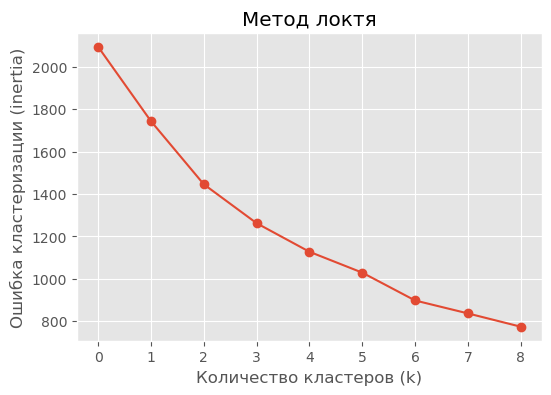

In [46]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(6, 4))
plt.plot(inertia, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Ошибка кластеризации (inertia)")
plt.title("Метод локтя")
plt.show()

***Оптимальное k = 4***

In [47]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

cluster_labels = kmeans.labels_
data['Cluster'] = cluster_labels
data

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,Cluster
0,Influenza,1,0,1,1,19,0,0,1,1,1
1,Common Cold,0,1,1,0,25,0,1,1,0,3
2,Eczema,0,1,1,0,25,0,1,1,0,3
3,Asthma,1,1,0,1,25,1,1,1,1,2
4,Asthma,1,1,0,1,25,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
344,Stroke,1,0,1,0,80,0,2,2,1,0
345,Stroke,1,0,1,0,85,1,2,2,1,0
346,Stroke,1,0,1,0,85,1,2,2,1,0
347,Stroke,1,0,1,0,90,0,2,2,1,0


***Сведём таблицу кластеров***

In [48]:
cluster_disease = data.groupby(['Cluster', 'Disease']).size().unstack(fill_value=0)
cluster_disease

Disease,Acne,Allergic Rhinitis,Alzheimer's Disease,Anemia,Anxiety Disorders,Appendicitis,Asthma,Atherosclerosis,Autism Spectrum Disorder (ASD),Bipolar Disorder,...,Tonsillitis,Tourette Syndrome,Tuberculosis,Turner Syndrome,Typhoid Fever,Ulcerative Colitis,Urinary Tract Infection,Urinary Tract Infection (UTI),Williams Syndrome,Zika Virus
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1,2,3,1,1,1,2,1,1,1,...,0,1,0,2,0,1,1,2,1,2
1,0,1,0,0,2,0,9,0,0,0,...,1,0,3,0,0,0,1,0,0,0
2,0,1,0,0,1,0,11,0,0,0,...,0,0,0,0,0,2,1,1,0,0
3,0,2,2,0,2,0,1,0,0,0,...,0,0,0,0,2,2,2,0,0,0


***Выведем топ-3 болезни в каждом кластере***                    
***Мы видим, что болезни со схожей функциональностью, действительно находятся в одном кластере***

In [49]:
cluster_disease_counts = data.groupby(['Cluster', 'Disease']).size().reset_index(name='Count')
most_common_disease = cluster_disease_counts.groupby('Cluster').apply(lambda x: x.nlargest(3,'Count')).reset_index(drop=True)
print(most_common_disease)

    Cluster                  Disease  Count
0         0                   Stroke     10
1         0             Hypertension      5
2         0             Osteoporosis      5
3         1                   Asthma      9
4         1                Pneumonia      7
5         1                Influenza      6
6         2                   Asthma     11
7         2                 Migraine      4
8         2  Coronary Artery Disease      2
9         3             Osteoporosis      5
10        3                 Diabetes      4
11        3                   Eczema      3


/var/folders/g4/v5z2m8dn34z2p9v96d3pjscw0000gn/T/ipykernel_21424/3876981195.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_common_disease = cluster_disease_counts.groupby('Cluster').apply(lambda x: x.nlargest(3,'Count')).reset_index(drop=True)


***Визуализируем кластеры***

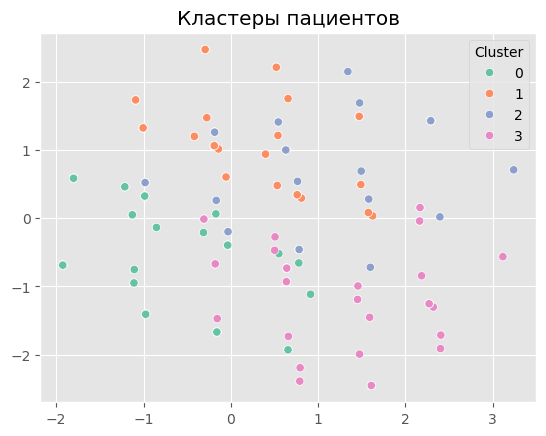

<Figure size 600x400 with 0 Axes>

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1],
    hue=data['Cluster'],
    palette='Set2'
)

plt.title("Кластеры пациентов")
plt.figure(figsize=(6, 4))
plt.show()


## Гипотезы

In [51]:
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

#### ***Хи-квадрат*** для проверки зависимости между затрудненным дыханием и повышенной температурой тела

***p-value < 0.05=>*** отвергаем нулевую гпиотезу и делаем вывод, что затрудненное дыхание и повышенная температура тела зависимы

In [52]:
contingency_table = pd.crosstab(data['Difficulty Breathing'], data['Fever'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Хи-квадрат :", chi2, "p-value:", p_value)


Хи-квадрат : 22.81397993474465 p-value: 1.7846281718167037e-06


## Анализ по графикам

In [53]:
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use("ggplot")
# sns.set_palette("husl")  

***Гистограмма кол-ва пациентов по возрастам***

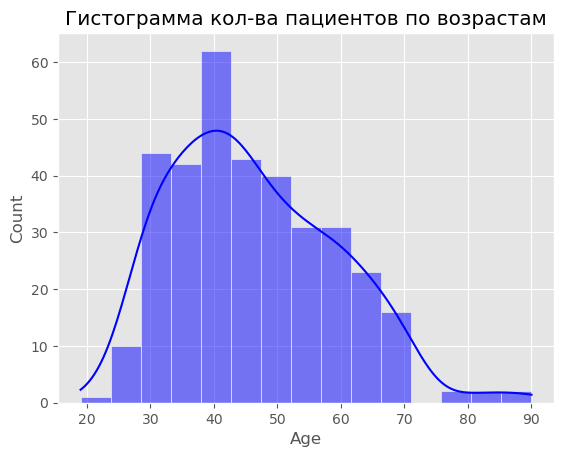

<Figure size 600x400 with 0 Axes>

In [54]:
sns.histplot(data_start["Age"], bins=15, kde=True, color="blue")
plt.title("Гистограмма кол-ва пациентов по возрастам")
plt.figure(figsize=(6,4))
plt.show()

***Построим тепловую карту корреляций между симптомами. Результат - корелляция между разными симптомами < 0.5***

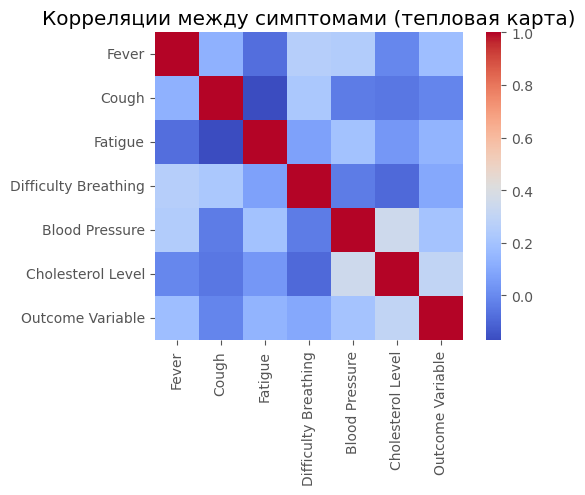

In [55]:
data_corr = data_start.drop(columns = ['Disease', 'Age', 'Gender'])
corr_matrix = data_corr.corr()
plt.figure(figsize=(6,4))
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm',     
    annot=False,          
    cbar=True,            
    square=True
)
plt.title("Корреляции между симптомами (тепловая карта)")
plt.show()

***Гистограмма распределения артериального давления относительно возраста***

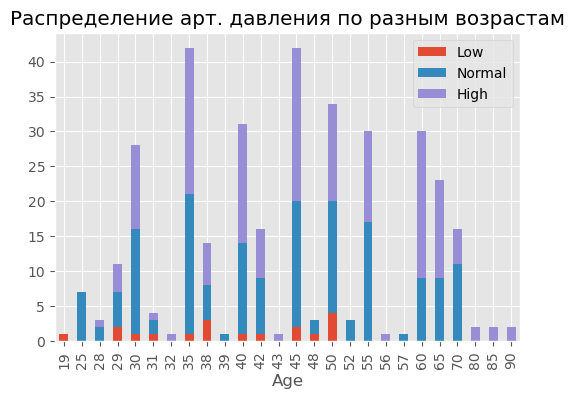

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pivot_df = pd.crosstab(data['Age'], data['Blood Pressure'])  
pivot_df.plot(kind='bar', stacked=True, figsize=(6,4))
plt.title('Распределение арт. давления по разным возрастам')
plt.legend(['Low','Normal','High'])
plt.show()
